# Parameter Estimation for Ion Exchange and GAC Breakthrough Data

This demonstration will present the steps for setting up and conducting a parameter estimation for the WaterTAP ion exchange (IX) and granular activated carbon (GAC) models. 

Both technologies are potential candidates for treated water impacted by per- and polyfluoroalkyl substances (PFAS). Critical to evaluating sorptive technologies for this purpose is accurate modeling of when the effluent concentration will hit a user (or regulation) defined limit, the "breakthrough concentration". This breakthrough time will dictate when the media is spent and either is regenerated or, like the case with PFAS, disposed, and will have significant implications for the cost of each process. In this demonstration, we will use publicly available data from an Orange County Water District (OCWD) report to obtain calibrated kinetic, mass transfer, and isotherm parameters. The data includes the effluent concentration measured at different breakthrough times in bed volumes (BV). We want to be able to have the model accurately predict the breakthrough time for a specific species and breakthrough concentration.

For this demonstration, we will use the Clark model for IX and the Constant Pattern Homogenous Surface Diffusion Model (CPHSDM) for GAC. Each model contains different parameters relevant to prediction of breakthrough time and is fully documented in the WaterTAP documentation.

<p align="center">
    <img src="ix_gac_parmest/images/report-cover.png" alt="Breakthrough Curve" width="400"/>
</p>

Figure 11 of the OCWD report presents the breakthrough data used in the pilot studies. In total, they evaluated eight different GAC media and four different IX resins.

Due to the lack of breakthrough for PFOS and PFHxS, we only consider the PFOA and PFBS data for the purposes of this demonstration. Of these four species, PFOA is the only one with a limit (10 ng/L).

<p align="center">
    <img src="ix_gac_parmest/images/breakthrough-curves.png" alt="Breakthrough Curve" width="800"/>
</p>

# Steps for Parameter Estimation

Much of the necessary steps for doing the parameter estimation is handled in the `parmest` module itself. We only need to create an `Estimator` and pass it the experimental data in the form of a list of `Experiment` class. Details on these two components and how they interact are availble in the [`parmest` documentation](https://pyomo.readthedocs.io/en/stable/explanation/analysis/parmest/index.html)

The general steps for performing the parameter estimation with WaterTAP are:

0. Import necessary packages
1. Collect and filter data
2. Write build function for model using experimental conditions
3. Generate list of `Experiment` objects 
4. Create `Estimator` object
5. Run parameter estimation

<!-- NOTE: For the purposes of this demonstration, some of the code is imported from tutorials/ix_gac_parmest -->

This demonstration will provide details of these steps for the IX model and then they will be repeated for the GAC model. Note that some of the code necessary for this demonstration is imported from **tutorials/ix_gac_parmest/ix_gac_parmest.py**

## Model Equations

The [WaterTAP IX model](https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/ion_exchange_0D.html) we will be using is an implementation of the Clark model. This model includes three parameters related to the bed capacity, equilibrium, and mass transfer of the solute of interest on to the media. The governing equation is shown below.

$$
\frac{\textcolor{red}{C_b}}{\textcolor{red}{C_0}} =
\frac{1}{\left( 1 +
\left(2^{\textcolor{RoyalBlue}{n} - 1} - 1\right)
\exp\left[
\frac{\textcolor{RoyalBlue}{k_T} Z (\textcolor{RoyalBlue}{n} - 1)}
{\textcolor{RoyalBlue}{BV_{50}} \, u_{bed}}
\left(\textcolor{RoyalBlue}{BV_{50}} - \textcolor{green}{BV}\right)
\right]
\right)^{\tfrac{1}{\textcolor{RoyalBlue}{n} - 1}}}
$$

<!-- **Color Legend:**   -->
- $u_{bed}$ = bed loading rate, adopted from pilot experiments
- $Z$ = bed depth, adopted from pilot experiments
- $\textcolor{red}{C_b/C_0}$ = Effluent concentration ratio, determined from pilot experiments
- $\textcolor{green}{BV}$ = Bed volumes treated, determined from pilot experiments
- $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ = Clark model parameters to be fit with parameter estimation

In essence, we want to estimate the values for $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ to know the $\textcolor{green}{BV}$ that the relative effluent concentration is $\textcolor{red}{ C_b/C_0}$. 


## Step 0: Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

# from ix_gac_parmest.ix_gac_parmest import plot_curve, filter_data
from ix_gac_parmest.ix_gac_parmest import *

## Step 1: Preparing Data

The data for this demo was extracted from the figure presented above into a .csv file. Then, the data was filtered such that the value is always below or above a certain threshold, and that the breakthrough concentration is generally increasing. Additionally, we ensure that no BV value is negative. 

In [2]:
ix_data = pd.read_csv("ix_gac_parmest/data/ix_ocwd_data.csv")
gac_data = pd.read_csv("ix_gac_parmest/data/gac_ocwd_data.csv")

<p align="center">
    <img src="ix_gac_parmest/images/ix_data_raw.png" alt="Breakthrough Curve" width="600"/>
</p>

<p align="center">
    <img src="ix_gac_parmest/images/gac_data_raw.png" alt="Breakthrough Curve" width="600"/>
</p>

Text(0.5, 1.0, 'Filtered IX Data Example')

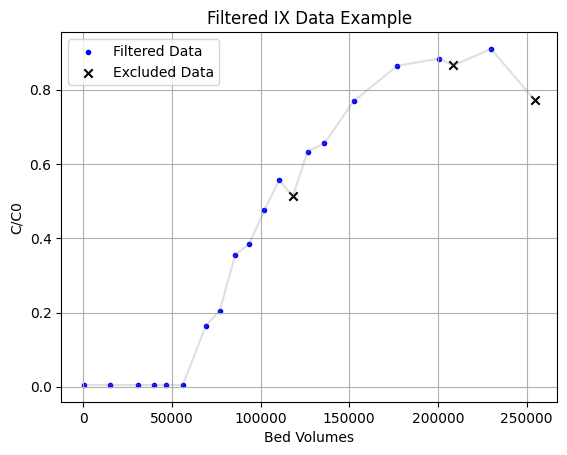

In [3]:
curve = 1
curve_data = ix_data[ix_data["curve_id"] == curve].copy()

# Results of filtering IX data
ix_data_filtered = filter_data(curve_data)
fig, ax = plot_curve1(ix_data_filtered)
ax.set_title("Filtered IX Data Example")

# Results of filtering GAC data
# curve_data = gac_data[gac_data["curve_id"] == curve].copy()
# gac_data_filtered = filter_data(curve_data)
# fig, ax = plot_curve(gac_data_filtered, x="all_bvs", y="all_cnorms", yleg="All data")
# ax.set_title("Filtered GAC Data Example")

# Step 2: Creating Model Build Function & Developing Initial Guess

A model build function must be developed in order to build the `Experiment` list. At a minimum, the build function must return the model. In addition, the build function *should* also:

1. Scale the model
2. Initialize the model
3. Solve the model

It is important that the model that is returned is stable because this is the model that will be used by the `Estimator` to do the parameter estimation routine. It is recommended that you test the stability of the model over a range of potential input conditions.

2025-09-02 12:35:35 [INFO] idaes.init.fs.unit.process_flow: Initialization Complete
2025-09-02 12:35:35 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2025-09-02 12:35:35 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2025-09-02 12:35:35 [WARNING] idaes.init.fs.unit: Trouble solving unit model fs.unit, trying one more time
2025-09-02 12:35:35 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2025-09-02 12:35:35 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
2025-09-02 12:35:36 [INFO] idaes.init.fs.unit.process_flow: Initialization Complete
2025-09-02 12:35:36 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2025-09-02 12:35:36 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2025-09-02 12:35:36 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2025-09-02 12:35:36 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solu

Text(0.5, 1.0, 'IX Curve 1\nTesting Initial Guess')

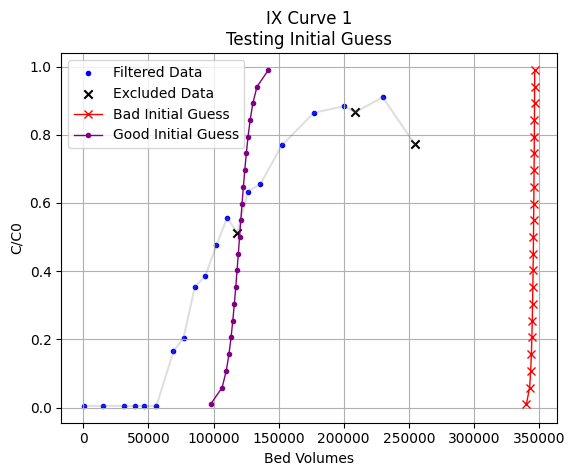

In [4]:
from pyomo.environ import Suffix, ComponentUID, assert_optimal_termination
from watertap.core.solvers import get_solver

solver = get_solver()
curve = 1
curve_data = ix_data[ix_data["curve_id"] == curve].copy()
species, resin = curve_data.species.iloc[0], curve_data.resin.iloc[0]

ix_data_filtered = filter_data(curve_data)
fig, ax = plot_curve1(ix_data_filtered)

bad_initial_guess = {
    "fs.unit.bv_50": 345678,
    "fs.unit.mass_transfer_coeff": 2,
    "fs.unit.freundlich_n": 80,
}

m = build_ix_ocwd_pilot(species=species, resin=resin, theta_dict=bad_initial_guess)


test_xs = np.linspace(0.01, 0.99, 21)
bvs_ig_bad = []

for x in test_xs:
    m.fs.unit.c_norm.fix(x)
    results = solver.solve(m)
    assert_optimal_termination(results)
    bvs_ig_bad.append(m.fs.unit.bv.value)

ax.plot(bvs_ig_bad, test_xs, color="red", marker="x", lw=1, label="Bad Initial Guess")

good_initial_guess = {
    "fs.unit.bv_50": 120000,
    "fs.unit.mass_transfer_coeff": 0.2,
    "fs.unit.freundlich_n": 2.0,
}

m = build_ix_ocwd_pilot(species=species, resin=resin, theta_dict=good_initial_guess)

bvs_ig_good = []

for x in test_xs:
    m.fs.unit.c_norm.fix(x)
    results = solver.solve(m)
    assert_optimal_termination(results)
    bvs_ig_good.append(m.fs.unit.bv.value)

ax.plot(bvs_ig_good, test_xs, color="purple", marker=".", lw=1, label="Good Initial Guess")

ax.legend()
ax.set_title("IX Curve 1\nTesting Initial Guess")

# Step 3: Creating a list of Experiments

Pyomo provides a template class `Experiment` to use to create the input list of experiments. Below is an inherited class for this application called `BreakthroughExperiment`. The class must include a `get_labeled_model` method that returns a model that:

* contains an `experiment_outputs` `Suffix` that contains the experimental data
* contains an `unknown_parmeters` `Suffix` that contains the parameters to be estimated
* has the variables that are being estimated *unfixed*

In [5]:
from pyomo.environ import Suffix, ComponentUID, assert_optimal_termination
from pyomo.contrib.parmest.experiment import Experiment
from idaes.core.util.model_statistics import degrees_of_freedom
from watertap.core.solvers import get_solver

solver = get_solver()


class BreakthroughExperiment(Experiment):
    def __init__(
        self,
        data,
        experiment_number,
        initial_guess,
        build_function,
        build_kwargs,
        xlabel="",
        ylabel="",
        thetas=[],
    ):
        self.data = data
        self.experiment_number = experiment_number
        self.thetas = thetas
        self.initial_guess = initial_guess
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.build_function = build_function
        self.build_kwargs = build_kwargs

        self.data_exp = self.data.loc[experiment_number]

    def create_model(self):
        self.model = self.build_function(**self.build_kwargs)
        self.unit_blk = self.model.fs.unit

        return self.model

    def finalize_model(self):

        model = self.model

        xval = self.data_exp["x"].astype(float)
        yval = self.data_exp["y"].astype(float)

        xvar = self.model.find_component(self.xlabel)
        yvar = self.model.find_component(self.ylabel)

        xvar.fix(xval)
        yvar.set_value(yval)

        print(f"\nDOF After Initialization = {degrees_of_freedom(model)}")

        results = solver.solve(model)
        assert_optimal_termination(results)

        for theta in self.thetas:
            v = self.model.find_component(theta)
            v.unfix()

        print(f"\nDOF Into Parmest = {degrees_of_freedom(model)}")

        return self.model

    def label_model(self):

        xval = self.data_exp["x"].astype(float)
        yval = self.data_exp["y"].astype(float)
        xvar = self.model.find_component(self.xlabel)
        yvar = self.model.find_component(self.ylabel)

        self.model.experiment_outputs = Suffix(direction=Suffix.LOCAL)
        self.model.experiment_outputs.update(
            [
                (
                    xvar,
                    xval,
                ),
                (yvar, yval),
            ]
        )
        self.model.unknown_parameters = Suffix(direction=Suffix.LOCAL)
        self.model.unknown_parameters.update(
            [
                (k, ComponentUID(k))
                for k in [self.model.find_component(theta) for theta in self.thetas]
            ]
        )
        return self.model

    def get_labeled_model(self):
        m = self.create_model()
        m = self.finalize_model()
        m = self.label_model()

        return m


def create_experiment_list(
    filtered_data, initial_guess, build_function, build_kwargs, xlabel, ylabel, thetas
):

    experiment_list = []
    exp_dict = {
        "experiment_number": [
            x for x in range(len(filtered_data["filtered_x"].dropna()))
        ],
        "x": filtered_data["filtered_x"].dropna().values,
        "y": filtered_data["filtered_y"].dropna().values,
    }
    df_exp = pd.DataFrame.from_dict(exp_dict).set_index("experiment_number")

    for num in df_exp.index:
        experiment_list.append(
            BreakthroughExperiment(
                df_exp,
                num,
                initial_guess,
                build_function,
                build_kwargs,
                xlabel=xlabel,
                ylabel=ylabel,
                thetas=thetas,
            )
        )

    return experiment_list

In [6]:
curve = 1
curve_data = ix_data[ix_data["curve_id"] == curve].copy()
species, resin = curve_data.species.iloc[0], curve_data.resin.iloc[0]

ix_data_filtered = filter_data(curve_data)
initial_guess = {
    "fs.unit.bv_50": 120000,
    "fs.unit.mass_transfer_coeff": 0.2,
    "fs.unit.freundlich_n": 2.0,
}
ix_data_filtered = filter_data(curve_data)

build_kwargs = {"species": species, "resin": resin, "theta_dict": initial_guess}

xlabel = f"fs.unit.c_norm[{species}]"
ylabel = "fs.unit.bv"
thetas = ["fs.unit.bv_50", "fs.unit.mass_transfer_coeff", "fs.unit.freundlich_n"]

experiment_list = create_experiment_list(
    ix_data_filtered,
    initial_guess,
    build_ix_ocwd_pilot,
    build_kwargs,
    xlabel=xlabel,
    ylabel=ylabel,
    thetas=thetas,
)
experiment = experiment_list[0]
m = experiment.get_labeled_model()

for theta in thetas:
    theta_var = m.find_component(theta)
    assert not theta_var.is_fixed()

2025-09-02 12:35:37 [INFO] idaes.init.fs.unit.process_flow: Initialization Complete
2025-09-02 12:35:37 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2025-09-02 12:35:38 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2025-09-02 12:35:38 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2025-09-02 12:35:38 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found

DOF After Initialization = 0

DOF Into Parmest = 3


# Step 4: Running Parameter Estimation

Objective Function Value: 223689678.0
Parameter: fs.unit.bv_50, Estimate: 116305.18
Parameter: fs.unit.mass_transfer_coeff, Estimate: 0.44
Parameter: fs.unit.freundlich_n, Estimate: 1.05
2025-09-02 12:35:48 [INFO] idaes.init.fs.unit.process_flow: Initialization Complete
2025-09-02 12:35:48 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2025-09-02 12:35:48 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2025-09-02 12:35:48 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2025-09-02 12:35:48 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found


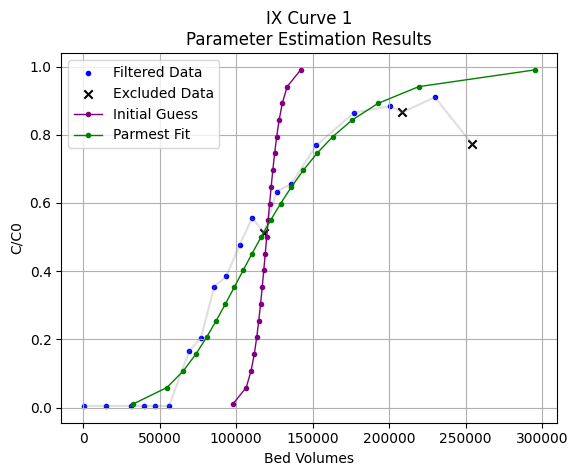

In [7]:
from pyomo.contrib.parmest.parmest import Estimator

SSE_sf = 1
def SSE(model):
    """
    Sum of squared error between `experiment_output` model and data values
    """
    expr = sum((y - y_hat) ** 2 for y, y_hat in model.experiment_outputs.items())
    return expr * SSE_sf

curve = 1

curve_data = ix_data[ix_data["curve_id"] == curve].copy()
species, resin = curve_data.species.iloc[0], curve_data.resin.iloc[0]

ix_data_filtered = filter_data(curve_data)
initial_guess = {
    "fs.unit.bv_50": 120000,
    "fs.unit.mass_transfer_coeff": 0.2,
    "fs.unit.freundlich_n": 2.0,
}
ix_data_filtered = filter_data(curve_data)

build_kwargs = {"species": species, "resin": resin, "theta_dict": initial_guess}

xlabel = f"fs.unit.c_norm[{species}]"
ylabel = "fs.unit.bv"
thetas = ["fs.unit.bv_50", "fs.unit.mass_transfer_coeff", "fs.unit.freundlich_n"]

experiment_list = create_experiment_list(
    ix_data_filtered,
    initial_guess,
    build_ix_ocwd_pilot,
    build_kwargs,
    xlabel=xlabel,
    ylabel=ylabel,
    thetas=thetas,
)

pestimator = Estimator(experiment_list, obj_function=SSE)
# NOTE: You can optionally provide a list of variable names via the return_values keyword 
# to get the reconciled values back. In this demo, we run the model externally to include a 
# wider range of relative concentration values.
# obj, theta_estimate, bvs_est = pestimator.theta_est(return_values=["fs.unit.bv"])
obj, theta_estimate = pestimator.theta_est()

clear_output(wait=False)
print(f"Objective Function Value: {obj:.1f}")
for theta, val in theta_estimate.items():
    print(f"Parameter: {theta}, Estimate: {val:.2f}")

m = build_ix_ocwd_pilot(species=species, resin=resin, theta_dict=theta_estimate)
bvs_est = []
for x in test_xs:
    m.fs.unit.c_norm.fix(x)
    results = solver.solve(m)
    assert_optimal_termination(results)
    bvs_est.append(m.fs.unit.bv.value)

fig, ax = plot_curve1(ix_data_filtered)
ax.plot(bvs_ig_good, test_xs, color="purple", marker=".", lw=1, label="Initial Guess")
ax.plot(bvs_est, test_xs, marker='.', color="green", lw=1, label='Parmest Fit')
ax.set_title("IX Curve 1\nParameter Estimation Results")
_ = ax.legend()

<!-- # Creating a list of Experiments

Pyomo provides a template class `Experiment` to use to create the input list of experiments. Below is an inherited class for this application called `BreakthroughExperiment`. The class must include a `get_labeled_model` method that returns a model that:

* contains an `experiment_outputs` `Suffix` that contains the experimental data
* contains an `unknown_parmeters` `Suffix` that contains the parameters to be estimated
* has the variables (or, parameters) that are being estimated *unfixed*

Inputs for the `BreakthroughExperiment` class below are:

* `data`: the filtered experimental dataset
* `experiment_number`: a unique identifier for the experiment
* `initial_guess`: an initial guess for the thetas
* `build_function`: the model build function 
* `x_label`: name of the input variable. For these two models, this is the relative effluenct concentration (C/C0)
* `y_label`: name of the varible to be predicted. For these two models, this is the breakthrough time in BVs
* `build_kwargs`: dict any keyword arguments required for the build function
* `thetas`: list of strings of the parameters to be estimated

The `get_labeled_model` method proceeds as such:

1. build, scale, and initialize the model via the `build_function`
2. set the effluent concentration to be the experimental value
3. re-initialize and solve the model at the initial guess
4. unfix all the `theta` variables -->

## Running for all IX Curves

The following cell could be run to get parmest data for all IX curves.

In [8]:
# ix_data = pd.read_csv("ix_gac_parmest/data/ix_ocwd_data.csv")
# initial_guess = {
#     "fs.unit.bv_50": 120000,
#     "fs.unit.mass_transfer_coeff": 0.2,
#     "fs.unit.freundlich_n": 2.0,
# }


# ylabel = "fs.unit.bv"
# thetas = ["fs.unit.bv_50", "fs.unit.mass_transfer_coeff", "fs.unit.freundlich_n"]

# ix_parmest_results = pd.DataFrame()

# for curve in ix_data["curve_id"].unique():
        
#     curve_data = ix_data[ix_data["curve_id"] == curve].copy()
#     species, resin = curve_data.species.iloc[0], curve_data.resin.iloc[0]
#     xlabel = f"fs.unit.c_norm[{species}]"

#     print(f"Running curve {curve}:")
#     print(f"Resin = {resin}")
#     print(f"Species = {species}")
    
#     curve_results = {}

#     ix_data_filtered = filter_data(curve_data)
#     curve_results["filtered_x"] = ix_data_filtered["filtered_x"]
#     curve_results["filtered_y"] = ix_data_filtered["filtered_y"]

#     build_kwargs = {"species": species, "resin": resin, "theta_dict": initial_guess}

#     experiment_list = create_experiment_list(
#         ix_data_filtered,
#         initial_guess,
#         build_ix_ocwd_pilot,
#         build_kwargs,
#         xlabel=xlabel,
#         ylabel=ylabel,
#         thetas=thetas,
#     )

#     pestimator = Estimator(experiment_list, obj_function=SSE)
#     obj, theta_estimate = pestimator.theta_est()

#     m = build_ix_ocwd_pilot(species=species, resin=resin, theta_dict=theta_estimate)
#     bvs_est = []
#     for x in test_xs:
#         m.fs.unit.c_norm.fix(x)
#         results = solver.solve(m)
#         assert_optimal_termination(results)
#         bvs_est.append(m.fs.unit.bv.value)

#     curve_results["bvs_est"] = bvs_est
#     curve_results["test_xs"] = test_xs

#     curve_results = pd.DataFrame({k: pd.Series(v) for k, v in curve_results.items()})
#     curve_results["obj"] = obj
#     curve_results["resin"] = resin
#     curve_results["species"] = species
#     curve_results["curve_id"] = curve

#     for theta, val in theta_estimate.items():
#         curve_results[theta] = val

#     ix_parmest_results = pd.concat([ix_parmest_results, curve_results], ignore_index=True)
#     clear_output(wait=False)

# ix_parmest_results.to_csv("ix_gac_parmest/results/ix_parmest_results.csv")


In [9]:
# ix_parmest_results.to_csv("ix_gac_parmest/results/ix_parmest_results2.csv")

In [10]:
ix_parmest_results = pd.read_csv(f"ix_gac_parmest/results/ix_parmest_results.csv")

<p align="center">
    <img src="ix_gac_parmest/images/ix_parmest_results.png" alt="Breakthrough Curve" width="800"/>
</p>

In [ ]:
gac_parmest_results = pd.read_csv(f"ix_gac_parmest/results/gac_parmest_results.csv")

<p align="center">
    <img src="ix_gac_parmest/images/gac_parmest_results.png" alt="Breakthrough Curve" width="800"/>
</p>

In [11]:
curve = 1
gac_data = pd.read_csv("ix_gac_parmest/data/gac_ocwd_data.csv")
initial_guess = {
    "fs.unit.freund_k": 3.7,
    "fs.unit.freund_ninv": 0.8316,
}

xlabel = "fs.unit.conc_ratio_replace"
ylabel = "fs.unit.bed_volumes_treated"
thetas = ["fs.unit.freund_k", "fs.unit.freund_ninv"]

curve_data = gac_data[gac_data["curve_id"] == curve].copy()
species, media = gac_data.species.iloc[0], gac_data.media.iloc[0]

print(f"Running curve {curve}:")
print(f"Media = {media}")
print(f"Species = {species}")

gac_data_filtered = filter_data(curve_data)

build_kwargs = {"species": species, "media": media, "theta_dict": initial_guess}

experiment_list = create_experiment_list(
    gac_data_filtered,
    initial_guess,
    build_gac_ocwd_pilot,
    build_kwargs,
    xlabel=xlabel,
    ylabel=ylabel,
    thetas=thetas,
)

pestimator = Estimator(experiment_list, obj_function=SSE)
obj, theta_estimate = pestimator.theta_est()

m = build_gac_ocwd_pilot(species=species, media=media, theta_dict=theta_estimate)
bvs_est = []
for x in test_xs:
    m.fs.unit.conc_ratio_replace.fix(x)
    results = solver.solve(m)
    assert_optimal_termination(results)
    bvs_est.append(m.fs.unit.bed_volumes_treated.value)

# gac_parmest_results = pd.concat([gac_parmest_results, curve_results], ignore_index=True)
clear_output(wait=False)


In [ ]:
# gac_data = pd.read_csv("ix_gac_parmest/data/gac_ocwd_data.csv")
# initial_guess = {
#     "fs.unit.freund_k": 3.7,
#     "fs.unit.freund_ninv": 0.8316,
# }

# xlabel = "fs.unit.conc_ratio_replace"
# ylabel = "fs.unit.bed_volumes_treated"
# thetas = ["fs.unit.freund_k", "fs.unit.freund_ninv"]

# gac_parmest_results = pd.DataFrame()

# for curve in gac_data["curve_id"].unique():

#     curve_data = gac_data[gac_data["curve_id"] == curve].copy()
#     species, media = gac_data.species.iloc[0], gac_data.media.iloc[0]

#     print(f"Running curve {curve}:")
#     print(f"Media = {media}")
#     print(f"Species = {species}")
    
#     curve_results = {}

#     gac_data_filtered = filter_data(curve_data)
#     curve_results["filtered_x"] = gac_data_filtered["filtered_x"]
#     curve_results["filtered_y"] = gac_data_filtered["filtered_y"]

#     build_kwargs = {"species": species, "media": media, "theta_dict": initial_guess}

#     experiment_list = create_experiment_list(
#         gac_data_filtered,
#         initial_guess,
#         build_gac_ocwd_pilot,
#         build_kwargs,
#         xlabel=xlabel,
#         ylabel=ylabel,
#         thetas=thetas,
#     )
#     try:
#         pestimator = Estimator(experiment_list, obj_function=SSE)
#         obj, theta_estimate = pestimator.theta_est()

#         m = build_gac_ocwd_pilot(species=species, media=media, theta_dict=theta_estimate)
#         bvs_est = []
#         for x in test_xs:
#             m.fs.unit.conc_ratio_replace.fix(x)
#             results = solver.solve(m)
#             assert_optimal_termination(results)
#             bvs_est.append(m.fs.unit.bed_volumes_treated.value)

#         curve_results["bvs_est"] = bvs_est
#         curve_results["test_xs"] = test_xs

#         curve_results = pd.DataFrame({k: pd.Series(v) for k, v in curve_results.items()})
#         curve_results["obj"] = obj
#         curve_results["media"] = media
#         curve_results["species"] = species
#         curve_results["curve_id"] = curve

#         for theta, val in theta_estimate.items():
#             curve_results[theta] = val

#         gac_parmest_results = pd.concat([gac_parmest_results, curve_results], ignore_index=True)
#     except:
#         pass
#     clear_output(wait=False)

#     gac_parmest_results.to_csv("ix_gac_parmest/results/gac_parmest_results.csv")
# gac_parmest_results.to_csv("ix_gac_parmest/results/gac_parmest_results.csv")


# Technoeconomic Analysis

Now that we have our parameter dataset, we can set up a full-scale model and add costing to evaluate system technoeconomics. The state of California has an action effluent level of PFOA set to 10 ng/L. For the purposes of this demonstration, we assume we are treating 1 MGD flow rate and the design parameters for each are set to the defaults for the EPA-WBS models for each technology.


From the fitted pilot results, we choose the media that resulted in the longest breakthrough time for PFOA. For IX, this is the Evoqua PSR+ and for GAC this is Calgon F400. 

<p align="center">
    <img src="ix_gac_parmest/images/gac-c0-regen_frac-gac_usage_rate.png" alt="Breakthrough Curve" width="600"/>
</p>

<p align="center">
    <img src="ix_gac_parmest/images/gac-c0-regen_frac-LCOW.png" alt="Breakthrough Curve" width="600"/>
</p>

In [ ]:
from pyomo.environ import (
    ConcreteModel,
    Objective,
    Expression,
    value,
    Var,
    Param,
    Constraint,
    ComponentUID,
    Suffix,
    Set,
    assert_optimal_termination,
    check_optimal_termination,
    Block,
    TransformationFactory,
    log,
    log10,
    SolverFactory,
    units as pyunits,
)

from idaes.core.util.testing import initialization_tester

# import pyomo.contrib.parmest.parmest as parmest
from pyomo.network import Arc
from pyomo.util.check_units import assert_units_consistent

from idaes.core import (
    FlowsheetBlock,
    UnitModelCostingBlock,
    MaterialBalanceType,
    EnergyBalanceType,
    MomentumBalanceType,
    UnitModelBlockData,
    useDefault,
)

import idaes.core.util.scaling as iscale
from pyomo.util.calc_var_value import calculate_variable_from_constraint as cvc
from idaes.core.solvers import get_solver
from idaes.core.util.model_diagnostics import *
from idaes.core.util.model_statistics import *  # degrees_of_freedom, number_unused_variables, etc
from idaes.core.util.scaling import *  # calculate_scaling_factors, set_scaling_factor, get_scaling_factor, calculate_variable_from_constraint

# constraint_scaling_transform, unscaled_variables_generator, badly_scaled_var_generator,
# constraint_autoscale_large_jac, extreme_jacobian_rows, extreme_jacobian_columns


from watertap.core.util.initialization import check_dof
from watertap.core.util.model_diagnostics.infeasible import *  # print_infeasible_constraints, print_infeasible_bounds, etc
from watertap.costing import WaterTAPCosting

import itertools
import pandas as pd
import numpy as np
import math
from copy import deepcopy
from idaes.core import (
    FlowsheetBlock,
    MaterialFlowBasis,
    MaterialBalanceType,
    AqueousPhase,
    EnergyBalanceType,
)
from IPython.display import clear_output


# from matplotlib.ticker import PercentFormatter
import matplotlib.colors as colors
from matplotlib import ticker
from watertap.property_models.multicomp_aq_sol_prop_pack import MCASParameterBlock

# from watertap.property_models.air_water_equilibrium_properties import AirWaterEq
from watertap.unit_models import (
    IonExchangeDemin,
    IonExchangeBase,
    IonExchangeCPHSDM,
    IonExchangeClark,
    add_ss_approximation,
    GAC,
    # CPHSDMCalculationMethod
)
from watertap.unit_models.gac import CPHSDMCalculationMethod
from watertap.core.solvers import get_solver
from watertap.costing import WaterTAPCosting
from watertap.unit_models.tests.unit_test_harness import UnitTestHarness
from idaes.core import declare_process_block_class, MaterialFlowBasis
from idaes.core.scaling import CustomScalerBase, ConstraintScalingScheme
from pyomo.environ import ConcreteModel, Constraint, units, Var

from idaes.core import FlowsheetBlock

from idaes.core.solvers import get_solver
from idaes.core.initialization import (
    BlockTriangularizationInitializer,
    SingleControlVolumeUnitInitializer,
    ModularInitializerBase,
)
from idaes.core.util import DiagnosticsToolbox
from watertap.kurby import (
    make_test_dict,
    print_unit_solutions,
    print_results,
    check_scaling,
)
from idaes.core.util.model_statistics import (
    degrees_of_freedom,
    number_variables,
    number_total_constraints,
    number_unused_variables,
)


import pyomo.contrib.parmest.parmest as parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.util.calc_var_value import calculate_variable_from_constraint

from idaes.core import FlowsheetBlock
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.scaling import (
    calculate_scaling_factors,
    set_scaling_factor,
    get_scaling_factor,
    constraint_scaling_transform,
    set_variable_scaling_from_current_value,
    badly_scaled_var_generator,
    report_scaling_issues,
    unset_scaling_factor,
)
from idaes.core.util.exceptions import InitializationError
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core.surrogate.pysmo_surrogate import PysmoSurrogate

from watertap.core.util.model_diagnostics.infeasible import (
    print_infeasible_constraints,
    print_variables_close_to_bounds,
)
from watertap.property_models.multicomp_aq_sol_prop_pack import (
    MCASParameterBlock,
)
from watertap.unit_models.ion_exchange.util import (
    plot_initial_guess,
    plot_theta,
    plot_estimate_bv50,
    plot_curve,
    save_results,
    make_results_df,
    save_output,
    make_output_df,
    save_figs,
)
from watertap.unit_models.ion_exchange import IXParamEst
from watertap.kurby import (
    build_results_dict,
    results_dict_append,
    print_results,
    check_scaling_jac,
)
import yaml
import matplotlib.pyplot as plt

solver = get_solver()
solver.options["max_iter"] = 2000

from collections import defaultdict

import matplotlib.lines as mlines

# with open("pfas_properties.yaml", "r") as f:
#     pfas_properties = yaml.load(f, Loader=yaml.FullLoader)


# with open("resin_properties.yaml", "r") as f:
#     resin_properties = yaml.load(f, Loader=yaml.FullLoader)

# with open("gac_properties.yaml", "r") as f:
#     gac_properties = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:

def build_gac_ocwd_pilot(
    species="PFBS",
    media="calgon_f600",
    theta_dict=dict(),
    **kwargs,
):

    def apply_scaling(m):

        pfas_mol_flow = pyunits.convert(
            (pfas_data["c0"] * pyunits.ng / pyunits.L)
            / (pfas_data["mw"] * pyunits.kg / pyunits.mol)
            * flow_rate,
            to_units=pyunits.mol / pyunits.s,
        )
        rho = 1000 * pyunits.kg / pyunits.m**3
        h2o_mol_flow = pyunits.convert(
            (flow_rate * rho) / (0.018 * pyunits.kg / pyunits.mol),
            to_units=pyunits.mol / pyunits.s,
        )
        print(
            "H2O Mol Flow:",
            value(pyunits.convert(h2o_mol_flow, to_units=pyunits.mol / pyunits.s)),
        )
        print(
            "PFAS Mol Flow:",
            value(pyunits.convert(pfas_mol_flow, to_units=pyunits.mol / pyunits.s)),
        )
        iscale.set_scaling_factor(m.fs.unit.bed_area, 1 / value(bed_area))
        iscale.set_scaling_factor(m.fs.unit.bed_diameter, 1 / value(bed_diameter))
        iscale.set_scaling_factor(m.fs.unit.bed_volume, 1 / value(bed_volume))
        iscale.set_scaling_factor(m.fs.unit.bed_length, 1 / value(bed_depth))
        iscale.set_scaling_factor(m.fs.unit.ebct, 1 / value(ebct))
        iscale.set_scaling_factor(m.fs.unit.velocity_sup, 1 / value(loading_rate))
        iscale.set_scaling_factor(m.fs.unit.equil_conc, 1e5)
        iscale.set_scaling_factor(
            m.fs.unit.process_flow.properties_in[0].flow_vol_phase["Liq"], 1 / value(flow_rate)
        )
        iscale.set_scaling_factor(
            m.fs.unit.process_flow.properties_in[0].flow_mol_phase_comp["Liq", "H2O"],
            1 / value(h2o_mol_flow),
        )
        iscale.set_scaling_factor(
            m.fs.unit.process_flow.properties_in[0].flow_mol_phase_comp["Liq", species],
            1 / value(pfas_mol_flow),
        )
        iscale.set_scaling_factor(
            m.fs.unit.process_flow.properties_in[0].flow_mass_phase_comp["Liq", "H2O"],
            1 / value(flow_rate * rho),
        )
        iscale.set_scaling_factor(
            m.fs.unit.process_flow.properties_in[0].flow_mass_phase_comp["Liq", species],
            1 / value(pfas_mol_flow / pfas_data["mw"]),
        )
        iscale.set_scaling_factor(
            m.fs.unit.process_flow.properties_in[0].conc_mass_phase_comp["Liq", species],
            1 / value(pfas_data["c0"] * 1e-9),
        )
        iscale.constraint_scaling_transform(
            m.fs.unit.eq_equilibrium_concentration[0.0, species], 1e2
        )
        iscale.constraint_scaling_transform(m.fs.unit.eq_mass_adsorbed[species], 1e5)
        iscale.constraint_scaling_transform(m.fs.unit.eq_number_bi, 1e10)
        iscale.constraint_scaling_transform(m.fs.unit.eq_bed_area[0.0], 1e5)
        iscale.constraint_scaling_transform(m.fs.unit.eq_dg[0.0, species], 1e5)
        iscale.constraint_scaling_transform(m.fs.unit.eq_number_bi, 1e10)
        iscale.constraint_scaling_transform(
            m.fs.unit.eq_minimum_operational_time_cps, 1e-6
        )
        iscale.constraint_scaling_transform(m.fs.unit.eq_operational_time, 1e-6)
        iscale.constraint_scaling_transform(m.fs.unit.eq_bed_volumes_treated, 1e-6)
        iscale.constraint_scaling_transform(m.fs.unit.eq_residence_time, 0.1)
        iscale.constraint_scaling_transform(m.fs.unit.eq_min_residence_time_cps, 0.1)

    bed_diameter = pyunits.convert(3.04 * pyunits.inch, to_units=pyunits.m)
    bed_depth = pyunits.convert(52 * pyunits.inch, to_units=pyunits.m)
    bed_volume = pyunits.convert(377.93 * pyunits.inch**3, to_units=pyunits.m**3)
    bed_area = pyunits.convert(7.27 * pyunits.inch**2, to_units=pyunits.m**2)
    flow_rate = pyunits.convert(
        0.1625 * pyunits.gallon / pyunits.minute, to_units=pyunits.m**3 / pyunits.s
    )
    loading_rate = pyunits.convert(
        3.25 * pyunits.gallon / pyunits.minute / pyunits.ft**2,
        to_units=pyunits.m**3 / pyunits.s / pyunits.m**2,
    )
    ebct = pyunits.convert(10.07 * pyunits.minute, to_units=pyunits.s)

    pfas_data = pfas_properties[species]
    media_data = gac_properties[media]

    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)

    m.fs.properties = MCASParameterBlock(
        solute_list=[species],
        mw_data={"H2O": 0.018, species: pfas_data.get("mw", 0.250)},
        ignore_neutral_charge=True,
        diffus_calculation="HaydukLaudie",
        molar_volume_data={
            ("Liq", species): pfas_data.get("molar_volume", 0.000250),
        },
    )
    m.fs.unit = GAC(
        property_package=m.fs.properties,
        film_transfer_coefficient_type="calculated",
        surface_diffusion_coefficient_type="fixed",
        cphsdm_calaculation_method="surrogate",
        add_trapezoidal_effluent_approximation=False,
    )
    # scaling
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1e3, index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1e12, index=("Liq", species)
    )
    unit_feed = m.fs.unit.process_flow.properties_in[0]
    unit_feed.flow_vol_phase
    unit_feed.conc_mass_phase_comp
    iscale.calculate_scaling_factors(m)

    # feed specifications
    unit_feed.pressure.fix(101325)
    unit_feed.temperature.fix(273.15 + 25)
    unit_feed = m.fs.unit.process_flow.properties_in.calculate_state(
        var_args={
            ("flow_vol_phase", "Liq"): 2e-8,
            ("conc_mass_phase_comp", ("Liq", species)): 4e-9,
        },
        hold_state=True,
    )

    m.fs.unit.freund_k.fix(3.7)
    m.fs.unit.freund_ninv.fix(0.8316)
    m.fs.unit.ds.fix(2e-13)
    m.fs.unit.particle_dens_app.fix(722)
    m.fs.unit.particle_dia.fix(0.00106)
    m.fs.unit.ebct.fix(300)  # seconds
    m.fs.unit.bed_voidage.fix(0.449)
    m.fs.unit.bed_length.fix(6)  # assumed
    m.fs.unit.shape_correction_factor.fix()

    m.fs.unit.conc_ratio_replace.fix(0.50)
    for v in m.fs.unit.component_objects(Var):
        v.domain = Reals
        v.setlb(None)
    print(f"dof = {degrees_of_freedom(m)}")

    assert degrees_of_freedom(m) == 0

    m.fs.unit.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)
    m.fs.properties.mw_comp[species] = pfas_data["mw"]
    m.fs.properties.molar_volume_phase_comp["Liq", species] = pfas_data["molar_volume"]

    # recalculate desired inlet flow and effluent target, based on conditions and new mw
    m.fs.unit.process_flow.properties_in[0].flow_mol_phase_comp["Liq", "H2O"].unfix()
    m.fs.unit.process_flow.properties_in[0].flow_mol_phase_comp["Liq", species].unfix()
    m.fs.unit.process_flow.properties_in.calculate_state(
        var_args={
            ("flow_vol_phase", "Liq"): flow_rate,
            ("conc_mass_phase_comp", ("Liq", species)): pfas_data["c0"] * 1e-9,
        },
        hold_state=True,
    )

    m.fs.unit.particle_dens_app.fix(media_data["density"])
    m.fs.unit.particle_dia.fix(media_data["diameter"])
    m.fs.unit.ebct.fix(ebct)
    m.fs.unit.bed_length.fix(bed_depth)
    m.fs.unit.velocity_sup.set_value(bed_depth / ebct)

    apply_scaling(m)

    for v, ig in theta_dict.items():
        vv = m.find_component(v)
        vv.fix(ig)

    # m.fs.unit.ds.setlb(1e-16)
    # m.fs.unit.ds.setub(1e-13)

    m.fs.unit.freund_ninv.setlb(0.01)
    m.fs.unit.freund_ninv.setub(0.99)

    m.fs.unit.freund_k.setlb(1e-8)
    m.fs.unit.freund_k.setub(100)

    results = solver.solve(m)
    assert_optimal_termination(results)

    return m


In [ ]:

def build_ocwd_gac_full(species="PFOA", media="calgon_virgin", flow_rate=1, c0=1, cb=10, c_norm=None):

    if c_norm is None:
        if cb >= c0:
            c_norm = 0.95
        else:
            c_norm = cb / c0

    flow_rate = flow_rate * pyunits.Mgallons / pyunits.day
    c0 = c0 * pyunits.ng / pyunits.L
    media_data = gac_properties[media]
    pfas_data = pfas_properties[species]

    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = MCASParameterBlock(
        solute_list=[species],
        mw_data={"H2O": 0.018, species: pfas_data["mw"]},
        ignore_neutral_charge=True,
        diffus_calculation="HaydukLaudie",
        molar_volume_data={
            ("Liq", species): pfas_data["molar_volume"],
        },
    )

    rho = 1000 * pyunits.kg / pyunits.m**3
    h2o_mol_flow = pyunits.convert(
        (flow_rate * rho) / (0.018 * pyunits.kg / pyunits.mol),
        to_units=pyunits.mol / pyunits.s,
    )
    pfas_mol_flow = pyunits.convert(
        (15.8 * pyunits.ng / pyunits.L)
        / (0.41407 * pyunits.kg / pyunits.mol)
        * flow_rate,
        to_units=pyunits.mol / pyunits.s,
    )
    print(1 / h2o_mol_flow())
    print(1 / pfas_mol_flow())
    
    m.fs.unit = GAC(
        property_package=m.fs.properties,
        film_transfer_coefficient_type="calculated",
        surface_diffusion_coefficient_type="fixed",
        cphsdm_calaculation_method="surrogate",
        add_trapezoidal_effluent_approximation=False,
    )
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1e-2, index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1e5, index=("Liq", species)
    )

    unit_feed = m.fs.unit.process_flow.properties_in[0]
    unit_feed.flow_vol_phase
    unit_feed.conc_mass_phase_comp

    iscale.calculate_scaling_factors(m)

    # feed specifications

    unit_feed.pressure.fix(101325)
    unit_feed.temperature.fix(273.15 + 25)
    m.fs.unit.process_flow.properties_in.calculate_state(
        var_args={
            ("flow_vol_phase", "Liq"): flow_rate,
            ("conc_mass_phase_comp", ("Liq", species)): c0,
        },
        hold_state=True
    )

    m.fs.unit.freund_ninv.setub(1)
    m.fs.unit.freund_k.fix(29.069478)
    m.fs.unit.freund_ninv.fix(0.920102)
    m.fs.unit.ds.fix(2e-13)
    m.fs.unit.particle_dens_app.fix(media_data["density"])
    m.fs.unit.particle_dia.fix(media_data["diameter"])
    m.fs.unit.ebct.fix(600)  # seconds
    m.fs.unit.bed_voidage.fix(0.449)
    m.fs.unit.bed_length.fix(7 *pyunits.ft)
    m.fs.unit.conc_ratio_replace.fix(c_norm)
    m.fs.unit.shape_correction_factor.fix()
    m.fs.unit.kf.set_value(2.3e-5)

    m.fs.unit.breakthrough_time_days = Expression(expr=pyunits.convert(m.fs.unit.operational_time, to_units=pyunits.days))


    constraint_scaling_transform(m.fs.unit.eq_mass_adsorbed[species], 1e5)
    constraint_scaling_transform(m.fs.unit.eq_number_bi, 1e10)
    constraint_scaling_transform(m.fs.unit.eq_bed_area[0.0], 1e5)
    constraint_scaling_transform(m.fs.unit.eq_dg[0.0, species], 1e5)
    constraint_scaling_transform(m.fs.unit.eq_number_bi, 1e10)
    constraint_scaling_transform(m.fs.unit.eq_minimum_operational_time_cps, 1e-6)
    constraint_scaling_transform(m.fs.unit.eq_operational_time, 1e-6)
    constraint_scaling_transform(m.fs.unit.eq_bed_volumes_treated, 1e-6)
    constraint_scaling_transform(m.fs.unit.eq_residence_time, 0.1)
    constraint_scaling_transform(m.fs.unit.eq_min_residence_time_cps, 0.1)

    iscale.set_scaling_factor(m.fs.unit.mass_adsorbed, 1e3)
    iscale.set_scaling_factor(m.fs.unit.gac_usage_rate, 1e3)
    iscale.set_scaling_factor(m.fs.unit.equil_conc, 1e5)

    for v in m.fs.unit.component_objects(Var):
        v.domain = pyo.Reals
        v.setlb(None)
    
    print(f"dof = {degrees_of_freedom(m)}")
    # cond = jacobian_cond(m)
    try:
        m.fs.unit.initialize()
    except:
        print_infeasible_constraints(m)
        print_variables_close_to_bounds(m)
        return m

    results = solver.solve(m)
    assert_optimal_termination(results)
    print(f"\n\ntermination = {results.solver.termination_condition}")

    m.fs.costing = WaterTAPCosting()

    m.fs.unit.costing = UnitModelCostingBlock(
        flowsheet_costing_block=m.fs.costing,
        # costing_method_arguments={"contactor_type": "gravity"},
    )
    m.fs.costing.cost_process()
    m.fs.costing.add_LCOW(m.fs.unit.process_flow.properties_in[0].flow_vol_phase["Liq"])
    m.fs.costing.add_specific_energy_consumption(m.fs.unit.process_flow.properties_in[0].flow_vol_phase["Liq"], name="SEC")
    m.fs.costing.gac_pressure.num_contactors_op.fix(1)
    m.fs.costing.gac_pressure.regen_frac.fix(0)
    m.fs.unit.costing.adsorbent_unit_cost_constraint.deactivate()
    m.fs.unit.costing.adsorbent_unit_cost.fix(7)
    results = solver.solve(m)

    assert_optimal_termination(results)
    print(f"\n\ntermination = {results.solver.termination_condition}")
    return m
